Like many cyclists and mountain bikers, I record and share my rides with [Strava](https://strava.com/). When I use my electric mountain bike, I normally export the relevant data to Strava from the [Bosch eBike Flow app](https://www.bosch-ebike.com/en/products/ebike-flow-app) that controls and monitors the performance of the motor and gets geolocation data from the mobile phone. I noticed that this data is sometimes affected by measurement errors that look like weird spikes on my routes. This is visible on this screenshot of a ride I did in Morgins last summer.

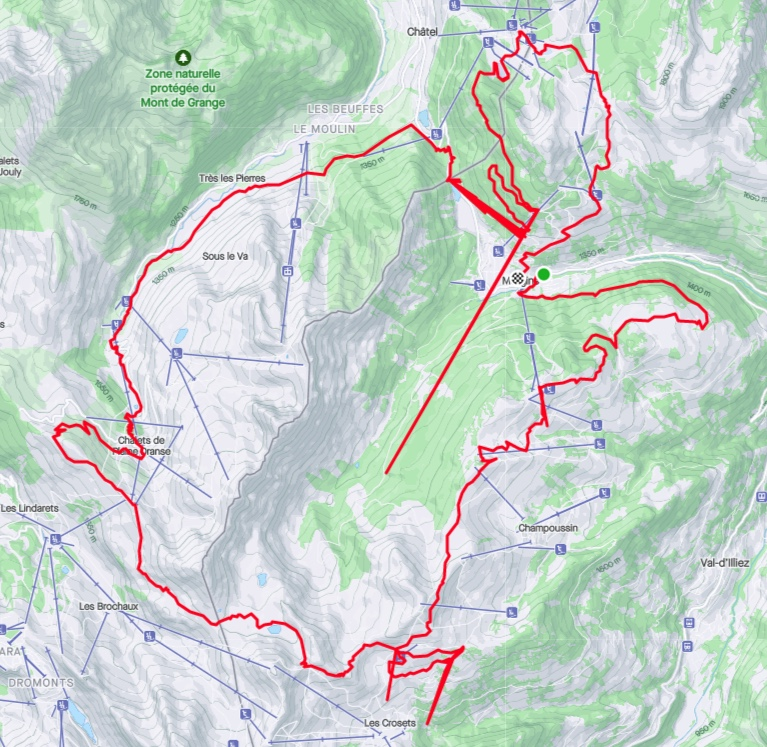

In [1]:
#| echo: false
from IPython.display import Image
Image("my_images/screenshot_strava.jpg")

To the data scientist in me who likes to correlate how much he rides week on week with the amount of ice cream he eats, this is frustrating because these errors are reflected in the total distances and elevation gains.

According to my satellite navigation guru friend Yannick, this can happen when the signal from a satellite bounces on cliffs before reaching the receiver, and I assume that the processing software puts strong priors on roads and trails that lead to funky corrections. For instance, the border crossing of Pas de Morgins seems to attract quite a lot of points from the nearby hillside.

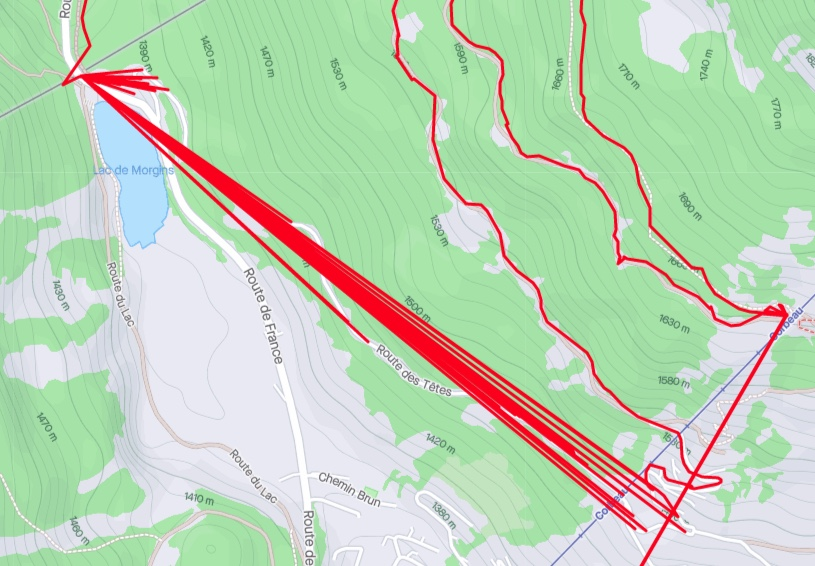

In [2]:
#| echo: false
Image("my_images/screenshot_pas_de_morgins.jpg")

Measurement errors can be somewhat corrected with signal processing techniques, but first we need to get the data. Strava allows you to export gpx files of your rides, which can be read with the [gpxpy](https://pypi.org/project/gpxpy/) library. The result is a time series of latitude, longitude and elevation measurements collected every second (except when the motor automatically turns off when I spend too much time eating snacks or petting cows and alpacas), and as a preprocessing step we can normalize them.

In [3]:
#| echo: false
import gpxpy
import gpxpy.gpx

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

In [4]:
#| code-fold: true

with open('my_data/Morgins_roundtrip.gpx') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation
            })

def normalize(series):
    return (series - series[0])/series.std()

def unnormalize(normalized_series, ref_series):
    return normalized_series * ref_series.std() + ref_series[0]

route_df = (pd.DataFrame(route_info)
            .assign(norm_lat=lambda x: normalize(x.latitude))
            .assign(norm_lon=lambda x: normalize(x.longitude))
            .assign(norm_elev=lambda x: normalize(x.elevation))
           )

route_df.head()

,time,latitude,longitude,elevation,norm_lat,norm_lon,norm_elev
0,2022-07-03 10:12:15+00:00,46.238541,6.861996,1302.3,0.000000,0.000000,0.000000
1,2022-07-03 10:12:16+00:00,46.238541,6.861996,1302.3,0.000000,0.000000,0.000000
2,2022-07-03 10:12:17+00:00,46.238670,6.861501,1303.2,0.005734,-0.017145,0.003903
3,2022-07-03 10:12:18+00:00,46.238636,6.861510,1303.3,0.004223,-0.016833,0.004336
4,2022-07-03 10:12:19+00:00,46.238636,6.861510,1303.3,0.004223,-0.016833,0.004336


Some of the errors like the one at Pas de Morgins seem to be characterized by the track alternating between the real underlying trajectory and a single erroneous point. If we count the occurrences of the most frequent coordinates, that point at [Pas de Morgins](https://geohack.toolforge.org/geohack.php?pagename=Pas_de_Morgins&params=46_14_59_N_06_50_45_E_type:pass_scale:50000) is precisely at the top of the list.

In [5]:
#| echo: false
pd.DataFrame(route_df.groupby(['latitude', 'longitude'])['time'].count().sort_values(ascending=False).head(6)).rename({'time': 'frequency'}, axis=1).reset_index()

,latitude,longitude,frequency
0,46.249691,6.845940,242
1,46.246140,6.861062,22
2,46.253025,6.845210,20
3,46.262466,6.851125,14
4,46.221539,6.791507,14
5,46.254601,6.854623,14


Therefore the first obvious fix would be to exclude the most frequently repeated points and try to replace them through interpolation of the real trajectory, for instance with a [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter), with the added benefit of reducing measurement noise on the rest of the trajectory.

In the version of the Kalman filter with no control input to the dynamical system, we assume that the data is generated by a latent Markov process (the state $z_{t+1}$ at a given time step only depends on the previous step $z_t$ and not the earlier ones) with normally distributed transitions,

$$
z_{t+1} \vert z_t \sim \mathcal{N} \left( F\, z_t + b, \ \Sigma_{tr} \right),
$$

where $F$ is a (possibly time-dependent) transition matrix, $b$ a bias vector and $\Sigma_{tr}$ the covariance matrix of the transition noise. We further assume that a similar Gaussian linear process generates the observations from a given latent state,

$$
x_t \vert z_t \sim \mathcal{N} \left( H\, z_t + c, \ \Sigma_{obs} \right),
$$

where $H$ is an observation matrix, $c$ a bias term and $\Sigma_{obs}$ the covariance of the observation process.

With these strong assumptions of normality and linear transformations, the posterior distribution of the latent states given observations can be derived through linear algebra operations. These operations are readily implemented in the [`tfd.LinearGaussianStateSpaceModel` distribution](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LinearGaussianStateSpaceModel) in the TensorFlow Probability library. The `forward_filter` method runs a Kalman filter to compute the filtered marginal distribution $P(z_t \vert x_{1..t})$ conditioned only on past observations, and the `posterior_marginal` method runs a Kalman smoother to compute the filtered marginal distribution $P(z_t \vert x_{1..T})$ conditioned on the full history of observations, including the future ones. These algorithms are discussed in details in section 8.3 of [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html). Since we have access to the whole GPS track, we will of course use the Kalman smoother. Conveniently, these methods also work if we condition only on a subset of the observations. Which observations should be ignored can be specified with an optional `mask` argument.

The first [example](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LinearGaussianStateSpaceModel#examples) in the official TensorFlow Probability documentation is precisely the tracking problem that interests us, where the latent space is the real position and the observation is the noisy measurement. Here we will increase the dimension of the latent space and add a velocity vector $\mathbf{v}$ and an acceleration vector $\mathbf{a}$ to the true position $\mathbf{s} = (latitude, longitude, elevation)$, so that $z = (\mathbf{s}, \mathbf{v}, \mathbf{a})$, and use transitions inspired by classical mechanics,

$$
z_{t+1} \vert z_t \sim \mathcal{N} \left( (\mathbf{s}_t + \mathbf{v}_t, \mathbf{v}_t + \mathbf{a}_t, 0), \Sigma_{tr} \right),
$$

with a diagonal transition covariance matrix $\Sigma_{tr}$ that carries much more uncertainty in its acceleration components. This kind of model is useful to estimate the velocity and acceleration solely from the position measurements (simply taking finite differences would be very inaccurate given the measurement noise), and it also incorporates knowledge from the laws of physics on how past states are going to influence future states. In a nutshell, it assumes that the forces affecting the bike and its rider are subject to random changes (I can brake, accelerate or turn, or collide with external obstacles), and my velocity and position are going to be a solution to Newton's second law of motion ($F = ma$). Such a model can extrapolate the future position from the current velocity, and correct the velocity and acceleration estimations from the measured positions.

Note that to estimate the physical velocity and acceleration, it would be better to transform the spherical coordinates into cartesian coordinates, but for our purpose of error correction, it should be good enough to use the (locally normalized) spherical ones.

In [6]:
#| code-fold: true
# Specify a Kalman filter
ndims = 3
noise_std = .2
n_steps = len(route_df)

model = tfd.LinearGaussianStateSpaceModel(
  num_timesteps=n_steps,
  transition_matrix=(tf.linalg.diag(2*ndims*[1.] + ndims*[0.])
                     + tf.pad(tf.eye(2 * ndims),
                              tf.constant([[0, ndims],
                                           [ndims, 0]]))),
  transition_noise=tfd.MultivariateNormalDiag(
   scale_diag=tf.concat([1e-9 * tf.ones([ndims]),
                         1e-9 * tf.ones([ndims]),
                         3e-2 * tf.ones([ndims])],
                        axis=0)),
  observation_matrix=tf.pad(tf.eye(ndims),
                            tf.constant([[0, 0],
                                         [0, 2*ndims]])),
  observation_noise=tfd.MultivariateNormalDiag(
   scale_diag=noise_std * tf.ones([ndims])),
  initial_state_prior=tfd.MultivariateNormalDiag(
   scale_diag=1e-9 * tf.ones([3*ndims])))

# Collect the observations into a tensor
x = tf.convert_to_tensor(
    route_df.loc[:n_steps-1, ['norm_lon', 'norm_lat', 'norm_elev']].values,
    dtype=tf.float32)

# Specify a mask to ignore measurements that occur more than 10 times
maximum_accepted_frequency = 10

rejected_df = pd.DataFrame(
    route_df.groupby(['latitude', 'longitude'])['time'].count()
    >maximum_accepted_frequency
)
    
rejected_df.columns = ['masked']

frequency_mask = route_df.merge(rejected_df,
                                how='left',
                                left_on=['latitude', 'longitude'],
                                right_index=True)['masked']

# Run a smoothing recursion to extract posterior marginals for locations
# at previous timesteps while rejecting the repeated measurements
posterior_means, posterior_covs = model.posterior_marginals(x,
                                                            mask=frequency_mask)

If we overlap the observed time series of normalized geographic coordinates with the filtered ones, it appears that the solid blocks on the observed values that correspond to the back and forth patterns do get corrected by the Kalman smoothing with masked repeated values.

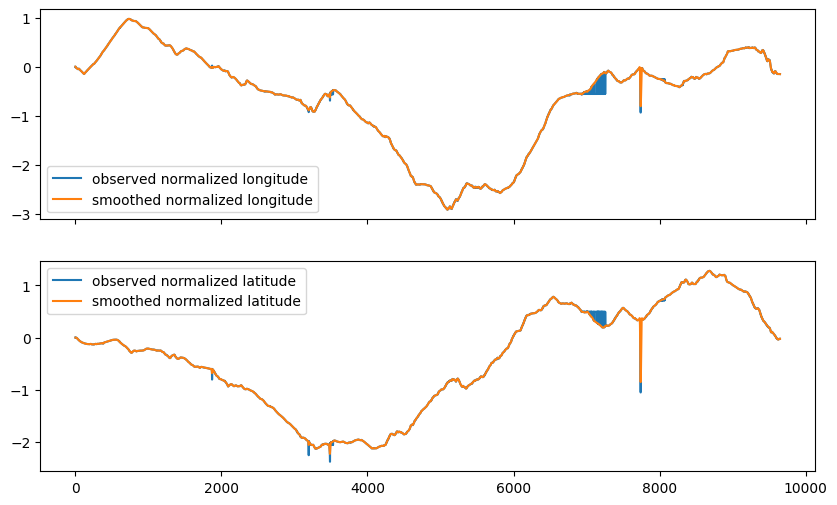

In [7]:
#| echo: false
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(6)

axs[0].plot(route_df.norm_lon, label='observed normalized longitude')
axs[0].plot(posterior_means[:,0], label='smoothed normalized longitude')
axs[0].legend()

axs[1].plot(route_df.norm_lat, label='observed normalized latitude')
axs[1].plot(posterior_means[:,1], label='smoothed normalized latitude')
axs[1].legend()

plt.show()

The spikes caused by isolated errors are a bit attenuated by the filter, provided the observation noise scale parameter is large enough. If it is too small, extreme points are interpreted as legitimate measurements because they are unlikely to be observation errors under the model specifications. But too large a scale parameter blurs out the inferred trajectory as it cannot resolve the trail geometry.

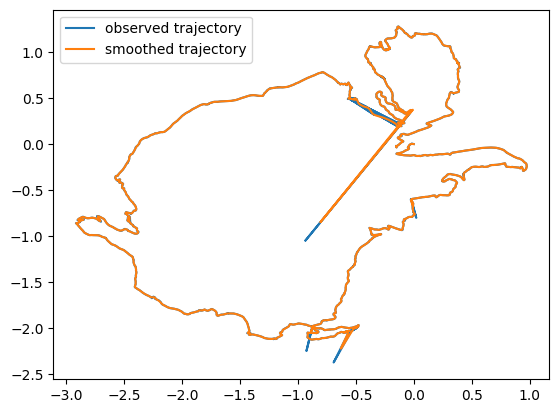

In [8]:
#| echo: false
plt.plot(route_df.norm_lon[:n_steps], route_df.norm_lat[:n_steps], label='observed trajectory')
plt.plot(posterior_means[:,0], posterior_means[:,1], label='smoothed trajectory')
plt.legend()
plt.show()

So the trick is to run a first Kalman smoother with an observation noise scale parameter that is large enough to identify the individual outliers (while masking the repeated measurements that we already identified), followed by a second one with lower noise while masking the individual outliers in addition to the repeated measurements to infer the true trajectory. The identification of individual outliers after the first smoothing can be achieved by measuring the distance between the observations and the posterior mean of the first Kalman smoother, and rejecting the observations that are beyond a certain threshold.

In [9]:
#| code-fold: true
# Compute the distance (Euclidean distance in the space of normalized
# coordinates) and set a mask beyond a threshold of 0.02

threshold = 0.02

filtered_lon = posterior_means[:,0]
filtered_lat = posterior_means[:,1]
filtered_elev = posterior_means[:,2]

delta = np.sqrt((route_df['norm_lon'] - filtered_lon)**2
                +(route_df['norm_lat'] - filtered_lat)**2
                +(route_df['norm_elev'] - filtered_elev)**2
               )

distance_mask = delta > threshold

# specify a second Kalman smoother with a lower noise parameter
noise_std_2 = .05

model2 = tfd.LinearGaussianStateSpaceModel(
  num_timesteps=n_steps,
  transition_matrix=(tf.linalg.diag(2*ndims*[1.] + ndims*[0.])
    + tf.pad(tf.eye(2 * ndims), tf.constant([[0, ndims],[ndims, 0]]))),
  transition_noise=tfd.MultivariateNormalDiag(
   scale_diag=tf.concat([1e-9 * tf.ones([ndims]),
                         1e-9 * tf.ones([ndims]),
                         3e-2 * tf.ones([ndims])], axis=0)),
  observation_matrix=tf.pad(tf.eye(ndims), tf.constant([[0, 0], [0, 2*ndims]])),
  observation_noise=tfd.MultivariateNormalDiag(
   scale_diag=noise_std_2 * tf.ones([ndims])),
  initial_state_prior=tfd.MultivariateNormalDiag(
   scale_diag=1e-9 * tf.ones([3*ndims])))

# apply the smoother with the combined masks
corrected_posterior_means, corrected_posterior_covs = (
    model2.posterior_marginals(x, mask=frequency_mask+distance_mask))

The posterior mean of the second smoother produces a clean estimation of the real trajectory, free of any weird spike. As a last step, we can rescale it and plot it on OpenStreetMap to admire the result and think of future bike rides!

In [10]:
#| echo: false
from IPython.display import IFrame
import folium

my_map = folium.Map(location=[route_df.latitude.mean(), route_df.longitude.mean()], zoom_start=12, control_scale=True)

corr_lon = unnormalize(corrected_posterior_means[:,0], route_df.longitude)
corr_lat = unnormalize(corrected_posterior_means[:,1], route_df.latitude)
coordinates = tf.stack([corr_lat, corr_lon], axis=1)

my_PolyLine=folium.PolyLine(locations=coordinates,weight=2.5)
my_map.add_child(my_PolyLine)

filepath = "my_data/map.html"
my_map.save(filepath)
IFrame(filepath, 750, 600)

## Acknowledgement
I would like to thank Maxime Baillifard for showing me his hometrails around Morgins, an area that seems to affect GPS signals like the Bermuda Triangle, and Yannick Stebler for providing a rational explanation about signals bouncing on cliffs that debunked that myth.